In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
from scipy.stats import pearsonr
import pandas as pd

import sys
sys.path.append('data')
import backboning

# Part 1: Network Analysis

In [3]:
G = nx.read_graphml("data/world_graph_attributes.graphml")

## 1. Qualitative Analysis

In [4]:
no_nodes = G.number_of_nodes()
no_edges=G.number_of_edges()
print("Number of nodes:", no_nodes)
print("Number of edges:", no_edges)

#Highest in
in_degrees = dict(G.in_degree())
sorted_nodes_in = sorted(in_degrees.items(), key=lambda x: x[1], reverse=True)
highest_in=sorted_nodes_in[:20]
print("\nHighest in-degree nodes and their in-degree value:", highest_in)

#Highest out 
out_degrees = dict(G.out_degree())
sorted_nodes_out = sorted(out_degrees.items(), key=lambda x: x[1], reverse=True)
highest_out=sorted_nodes_out[:5]
print(" \nHighest out-degree nodes and their out-degree value:", highest_out)

#Highest total
total_degrees = dict(G.degree())
sorted_nodes_total = sorted(total_degrees.items(), key=lambda x: x[1], reverse=True)
highest_total=sorted_nodes_total[:5]
print("\nHighest total-degree nodes and their total-degree value:", highest_total)

Number of nodes: 192
Number of edges: 2115

Highest in-degree nodes and their in-degree value: [('United_States', 115), ('France', 90), ('United_Kingdom', 89), ('Germany', 87), ('China', 62), ('India', 61), ('Spain', 57), ('Russia', 46), ('Japan', 39), ('Italy', 36), ('Portugal', 34), ('Egypt', 29), ('Iran', 29), ('Netherlands', 25), ('Iraq', 25), ('Guinea', 24), ('Philippines', 24), ('Cuba', 23), ('Hungary', 23), ('South_Africa', 22)]
 
Highest out-degree nodes and their out-degree value: [('Cuba', 30), ('Iran', 26), ('Russia', 24), ('Nicaragua', 24), ('Argentina', 23)]

Highest total-degree nodes and their total-degree value: [('United_States', 133), ('United_Kingdom', 107), ('Germany', 105), ('France', 99), ('India', 72)]


## 2. Degree distributions

### 2.1. In-degree and out-degree distributions

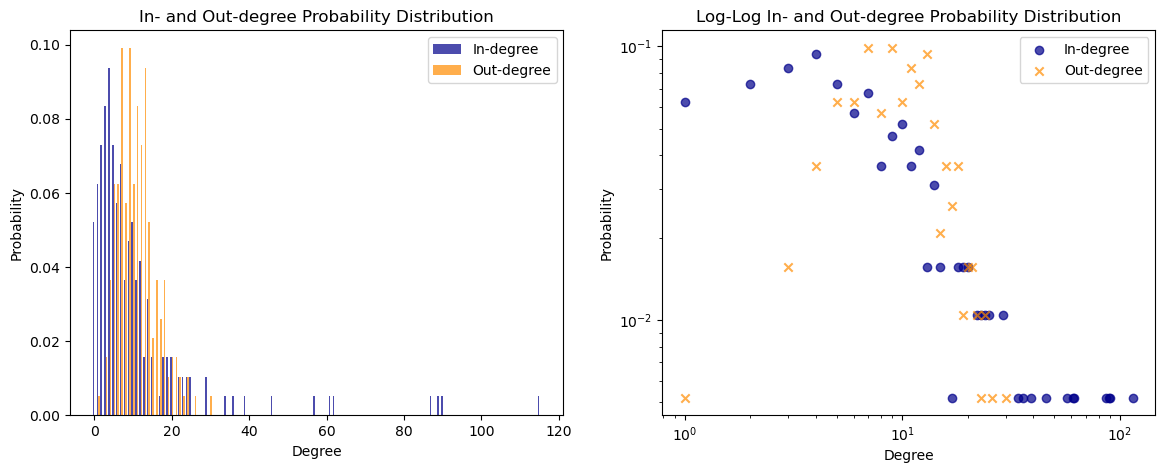

In [5]:
# in-degree and out-degree lists
in_d = [d for _, d in G.in_degree()]
out_d = [d for _, d in G.out_degree()]

in_d_sort = sorted(in_d)
out_d_sort = sorted(out_d)

# bins
max_deg = max(max(in_d_sort), max(out_d_sort))
min_deg = min(min(in_d_sort), min(out_d_sort))
v = np.arange(min_deg, max_deg + 2)  

# in counts
in_counts, in_bins = np.histogram(in_d_sort, bins=v)
# in probabilities
in_probs = in_counts / in_counts.sum()

# out counts
out_counts, out_bins = np.histogram(out_d_sort, bins=v)
# out probabilities
out_probs = out_counts / out_counts.sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(v[:-1]-0.2, in_probs, width=0.4, color='darkblue', label='In-degree', alpha=0.7)
axes[0].bar(v[:-1]+0.2, out_probs, width=0.4, color='darkorange', label='Out-degree', alpha=0.7)
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Probability')
axes[0].set_title('In- and Out-degree Probability Distribution')
axes[0].legend()

axes[1].scatter(v[:-1], in_probs, marker='o', color='darkblue', label='In-degree', alpha=0.7)
axes[1].scatter(v[:-1], out_probs, marker='x', color='darkorange', label='Out-degree', alpha=0.7)
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Probability')
axes[1].set_title('Log-Log In- and Out-degree Probability Distribution')
axes[1].legend()

plt.show()

To investigate if the in-degree and out-degree distributions follow a power law, their exponents were estimated using the `powerlaw` package. 

In [6]:
fit_in = powerlaw.Fit(in_d,discrete=True,verbose=False)
alpha_in = fit_in.alpha
xmin_in=fit_in.xmin
print("In-degree exponent (alpha):", alpha_in)
print("xmin:", xmin_in)

fit_out = powerlaw.Fit(out_d,discrete=True,verbose=False)
alpha_out = fit_out.alpha
xmin_out=fit_out.xmin
print("Out-degree exponent (alpha):", alpha_out)
print("xmin:", xmin_out)

In-degree exponent (alpha): 2.460478818409286
xmin: 9.0
Out-degree exponent (alpha): 8.922052361640876
xmin: 21.0


In order to check if the distributions could follow a different model, we compared power-law, log-normal and exponential distribution models. 

In [7]:
print("In-degree distribution model comparisons:")
R_ln_in, p_ln_in = fit_in.distribution_compare('power_law', 'lognormal')
print("Power-law vs lognormal: R =", R_ln_in, ", p =", p_ln_in)

R_exp_in, p_exp_in = fit_in.distribution_compare('power_law', 'exponential')
print("Power-law vs exponential: R =", R_exp_in, ", p =", p_exp_in)

R_expln_in, p_expln_in = fit_in.distribution_compare('lognormal', 'exponential')
print("Log-normal vs exponential: R =", R_expln_in, ", p =", p_expln_in)

print("\nOut-degree distribution model comparisons:")
R_ln_out, p_ln_out = fit_out.distribution_compare('power_law', 'lognormal')
print("Power-law vs lognormal: R =", R_ln_out, ", p =", p_ln_out)

R_exp_out, p_exp_out = fit_out.distribution_compare('power_law', 'exponential')
print("Power-law vs exponential: R =", R_exp_out, ", p =", p_exp_out)

R_expln_out, p_expln_out = fit_out.distribution_compare('lognormal', 'exponential')
print("Log-normal vs exponential: R =", R_expln_out, ", p =", p_expln_out)

In-degree distribution model comparisons:
Power-law vs lognormal: R = -0.31424322239286906 , p = 0.5551714729836246
Power-law vs exponential: R = 10.557681816492256 , p = 0.029199378221683767
Log-normal vs exponential: R = 10.871925038885147 , p = 0.012188251994433534

Out-degree distribution model comparisons:
Power-law vs lognormal: R = -0.1065296003825087 , p = 0.7271408933018562
Power-law vs exponential: R = -0.103208627962597 , p = 0.5941600128531492
Log-normal vs exponential: R = 0.003320972419911694 , p = 0.9764335107282895


### 2.2. Total-degree distribution

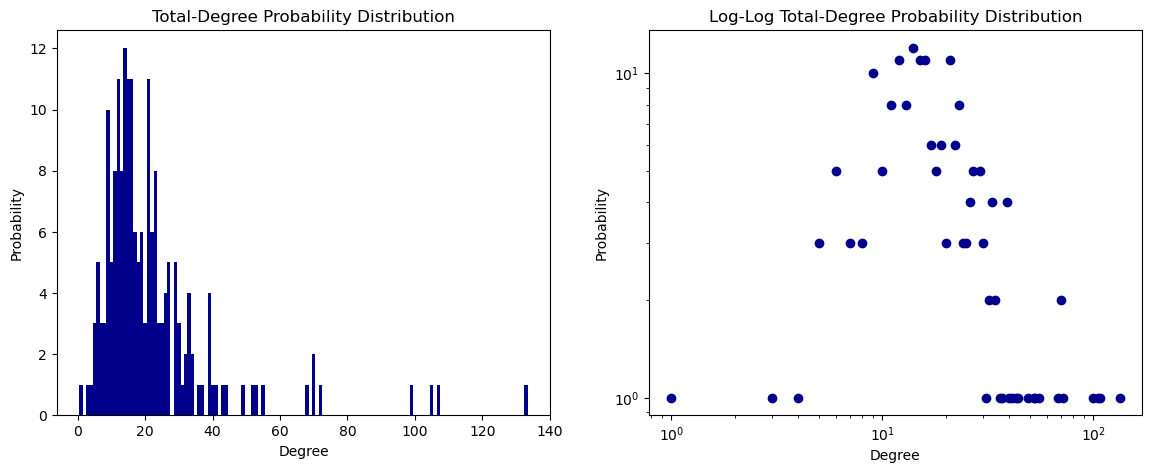

In [8]:
total_d = [d for _, d in G.degree()]
total_d_sort = sorted(total_d)

max_total=max(total_d_sort)
min_total=min(total_d_sort)
v_total=np.arange(min_total, max_total+2)

# counts
total_counts, total_bins = np.histogram(total_d_sort, bins=v_total)
# probabilities
total_probs = total_counts / total_counts.sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(total_bins[:-1], total_counts, width=np.diff(total_bins), color='darkblue')
axes[0].set_xlabel('Degree')
axes[0].set_ylabel('Probability')
axes[0].set_title('Total-Degree Probability Distribution')
    
axes[1].scatter(total_bins[:-1], total_counts, marker='o', color = 'darkblue')
axes[1].set_xscale("log")
axes[1].set_yscale("log")
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Probability')
axes[1].set_title('Log-Log Total-Degree Probability Distribution')
plt.show()

C:\Users\Maria\AppData\Local\Temp\ipykernel_21772\1886238199.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis', 15)


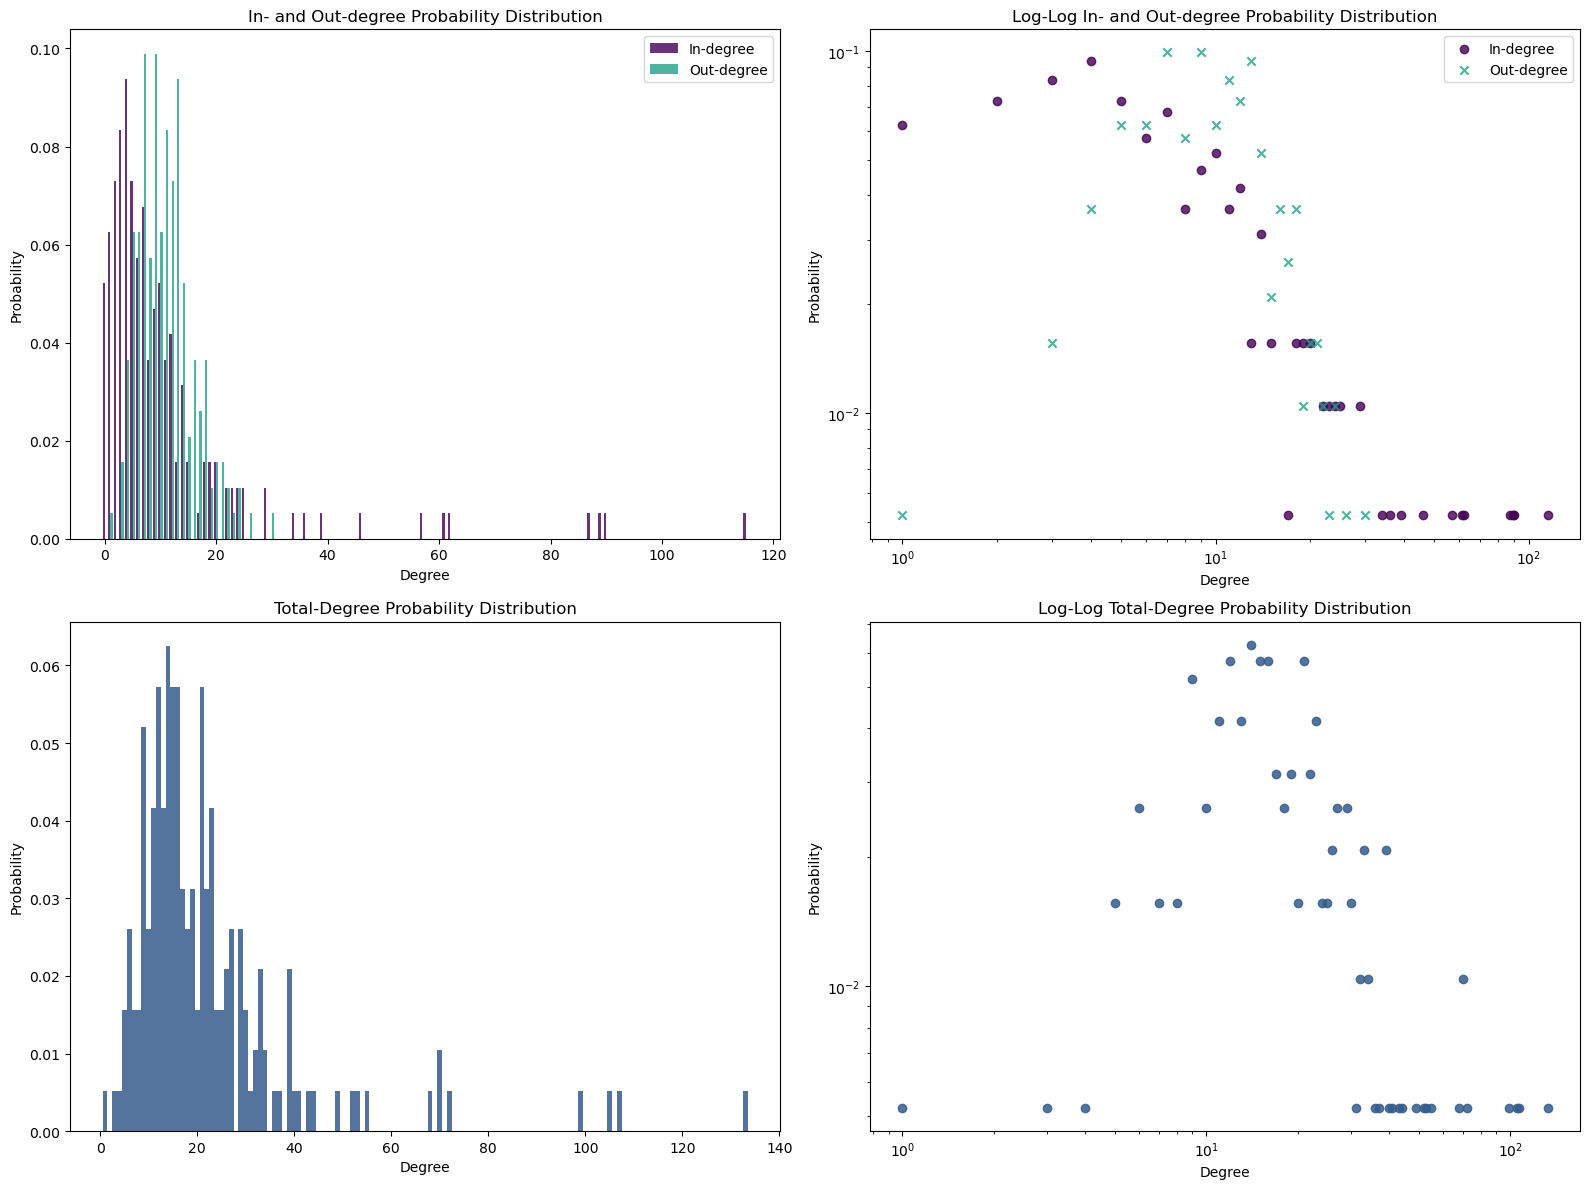

In [9]:
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt


# --- Choose colors from viridis ---
viridis = cm.get_cmap('viridis', 15)
colors = cm.viridis(np.linspace(0, 1, 15))
c_in = colors[0]
c_out = colors[8]
c_tot = colors[4]

# --- First: in/out degree distributions ---

in_d_sort = sorted(in_d)
out_d_sort = sorted(out_d)

max_deg = max(max(in_d_sort), max(out_d_sort))
min_deg = min(min(in_d_sort), min(out_d_sort))
v = np.arange(min_deg, max_deg + 2)

in_counts, in_bins = np.histogram(in_d_sort, bins=v)
out_counts, out_bins = np.histogram(out_d_sort, bins=v)

in_probs = in_counts / in_counts.sum()
out_probs = out_counts / out_counts.sum()

# --- Second: total degree distributions ---

total_d = [d for _, d in G.degree()]
total_d_sort = sorted(total_d)

max_total = max(total_d_sort)
min_total = min(total_d_sort)
v_total = np.arange(min_total, max_total + 2)

total_counts, total_bins = np.histogram(total_d_sort, bins=v_total)
total_probs = total_counts / total_counts.sum()

# --- Create 2×2 figure ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ---------------- TOP LEFT: In/Out normal ----------------
axes[0, 0].bar(v[:-1]-0.2, in_probs, width=0.4, color=c_in, label='In-degree', alpha=0.8)
axes[0, 0].bar(v[:-1]+0.2, out_probs, width=0.4, color=c_out, label='Out-degree', alpha=0.8)
axes[0, 0].set_xlabel('Degree')
axes[0, 0].set_ylabel('Probability')
axes[0, 0].set_title('In- and Out-degree Probability Distribution')
axes[0, 0].legend()

# ---------------- TOP RIGHT: In/Out log-log ----------------
axes[0, 1].scatter(v[:-1], in_probs, marker='o', color=c_in, label='In-degree', alpha=0.8)
axes[0, 1].scatter(v[:-1], out_probs, marker='x', color=c_out, label='Out-degree', alpha=0.8)
axes[0, 1].set_xscale("log")
axes[0, 1].set_yscale("log")
axes[0, 1].set_xlabel('Degree')
axes[0, 1].set_ylabel('Probability')
axes[0, 1].set_title('Log-Log In- and Out-degree Probability Distribution')
axes[0, 1].legend()

# ---------------- BOTTOM LEFT: Total normal ----------------
axes[1, 0].bar(total_bins[:-1], total_probs, width=np.diff(total_bins), color=c_tot, alpha=0.85)
axes[1, 0].set_xlabel('Degree')
axes[1, 0].set_ylabel('Probability')
axes[1, 0].set_title('Total-Degree Probability Distribution')

# ---------------- BOTTOM RIGHT: Total log-log ----------------
axes[1, 1].scatter(total_bins[:-1], total_probs, marker='o', color=c_tot, alpha=0.85)
axes[1, 1].set_xscale("log")
axes[1, 1].set_yscale("log")
axes[1, 1].set_xlabel('Degree')
axes[1, 1].set_ylabel('Probability')
axes[1, 1].set_title('Log-Log Total-Degree Probability Distribution')

plt.tight_layout()
plt.show()


To investigate if the total-degree distributions follow a power law, the exponent was estimated using the `powerlaw` package. To check if the distributions could follow a different model, we compared power-law, log-normal and exponential distribution models. 

In [10]:
fit_total = powerlaw.Fit(total_d,discrete=True)
alpha_total = fit_total.alpha
xmin_total = fit_total.xmin
print("In-degree exponent (alpha):", alpha_total)
print("xmin:", xmin_total)

R_ln_out, p_ln_out = fit_total.distribution_compare('power_law', 'lognormal')
print("\nPower-law vs lognormal: R =", R_ln_out, ", p =", p_ln_out)

R_exp_out, p_exp_out = fit_total.distribution_compare('power_law', 'exponential')
print("Power-law vs exponential: R =", R_exp_out, ", p =", p_exp_out)

R_expln_out, p_expln_out = fit_total.distribution_compare('lognormal', 'exponential')
print("Log-normal vs exponential: R =", R_expln_out, ", p =", p_expln_out)

Calculating best minimal value for power law fit
In-degree exponent (alpha): 3.2242657700949136
xmin: 22.0

Power-law vs lognormal: R = -0.08512335032450125 , p = 0.7589328668041653
Power-law vs exponential: R = 4.476561699048047 , p = 0.12722236931743178
Log-normal vs exponential: R = 4.561685049372554 , p = 0.08732329684278976


## 4. Centrality

We focus on three types: degree centrality, betweenness centrality and eigenvector centrality.

**In-degree**  **and out-degree centrality**

In [11]:
indegree_c = nx.in_degree_centrality(G)
sorted_in = sorted(indegree_c.items(), key=lambda x: x[1], reverse=True)
top5_in = [sorted_in[i][0] for i in range(5)]
print("Top 5 nodes by in-degree centrality:", top5_in)

outdegree_c = nx.out_degree_centrality(G)
sorted_out = sorted(outdegree_c.items(), key=lambda x: x[1], reverse=True)
top5_out = [sorted_out[i][0] for i in range(5)]
print("Top 5 nodes by out-degree centrality:", top5_out)

Top 5 nodes by in-degree centrality: ['United_States', 'France', 'United_Kingdom', 'Germany', 'China']
Top 5 nodes by out-degree centrality: ['Cuba', 'Iran', 'Russia', 'Nicaragua', 'Argentina']


**Betweenness centrality**

In [12]:
bet_c=nx.betweenness_centrality(G) 
sorted_bet_c = sorted(bet_c.items(), key=lambda x: x[1], reverse=True) 
print("Top 5 nodes by betweenness centrality:")
for node, value in sorted_bet_c[:5]:
    print(f"{node}: {value:.4f}")

Top 5 nodes by betweenness centrality:
Cuba: 0.1046
United_States: 0.0888
Russia: 0.0797
United_Kingdom: 0.0778
Germany: 0.0763


**In-**  **and out-eigenvector centrality**

In [13]:
ineig_c = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-06) 
top5_in = sorted(ineig_c.items(), key=lambda x: x[1], reverse=True)
print("Top 5 nodes by in-eigenvector centrality:")
for node, value in top5_in[:5]:
    print(f"{node}: {value:.4f}")

outeig_c = nx.eigenvector_centrality(G.reverse(), max_iter=1000, tol=1e-06) 
top5_out = sorted(outeig_c.items(), key=lambda x: x[1], reverse=True)
print("\nTop 5 nodes by out-eigenvector centrality:")
for node, value in top5_out[:5]:
    print(f"{node}: {value:.4f}")

Top 5 nodes by in-eigenvector centrality:
Germany: 0.3508
United_States: 0.3491
France: 0.3422
United_Kingdom: 0.2930
Russia: 0.2632

Top 5 nodes by out-eigenvector centrality:
Cuba: 0.1878
Iran: 0.1563
Israel: 0.1499
Nicaragua: 0.1491
Russia: 0.1485


### 4.1. Betweenness centrality vs degree centrality

Pearson correlation (In-Degree): 0.7866808435410306
Pearson correlation (Out-Degree): 0.5725470746839684


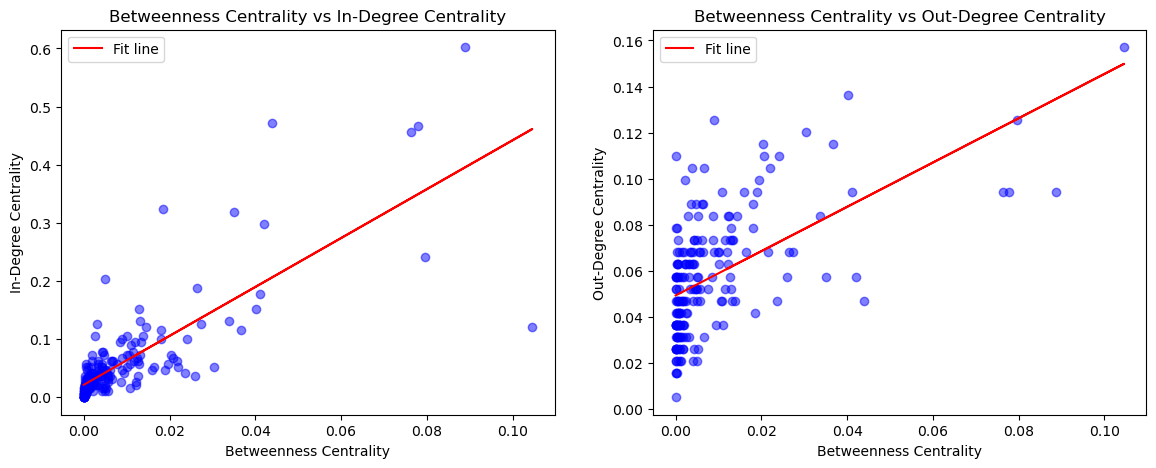

In [14]:
bet_c_list = list(bet_c.values())
indegree_c_list = list(indegree_c.values())
outdegree_c_list = list(outdegree_c.values())

pearson_corr_in = pearsonr(bet_c_list, indegree_c_list)
pearson_corr_out = pearsonr(bet_c_list, outdegree_c_list)
print("Pearson correlation (In-Degree):", pearson_corr_in[0])
print("Pearson correlation (Out-Degree):", pearson_corr_out[0])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(bet_c_list, indegree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(bet_c_list, indegree_c_list, 1)
axes[0].plot(bet_c_list, slope * np.array(bet_c_list) + intercept, color='red', label='Fit line')
axes[0].set_title(f"Betweenness Centrality vs In-Degree Centrality")
axes[0].set_xlabel("Betweenness Centrality")
axes[0].set_ylabel("In-Degree Centrality")
axes[0].legend()

axes[1].scatter(bet_c_list, outdegree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(bet_c_list, outdegree_c_list, 1)
axes[1].plot(bet_c_list, slope * np.array(bet_c_list) + intercept, color='red', label='Fit line')
axes[1].set_title(f"Betweenness Centrality vs Out-Degree Centrality")
axes[1].set_xlabel("Betweenness Centrality")
axes[1].set_ylabel("Out-Degree Centrality")
axes[1].legend()
plt.show()

### 4.2. Eigenvector centrality vs degree centrality

Pearson correlation (In-Degree vs In-Eigenvector): 0.9262261683026625
Pearson correlation (Out-Degree vs Out-Eigenvector): 0.9467217905565464


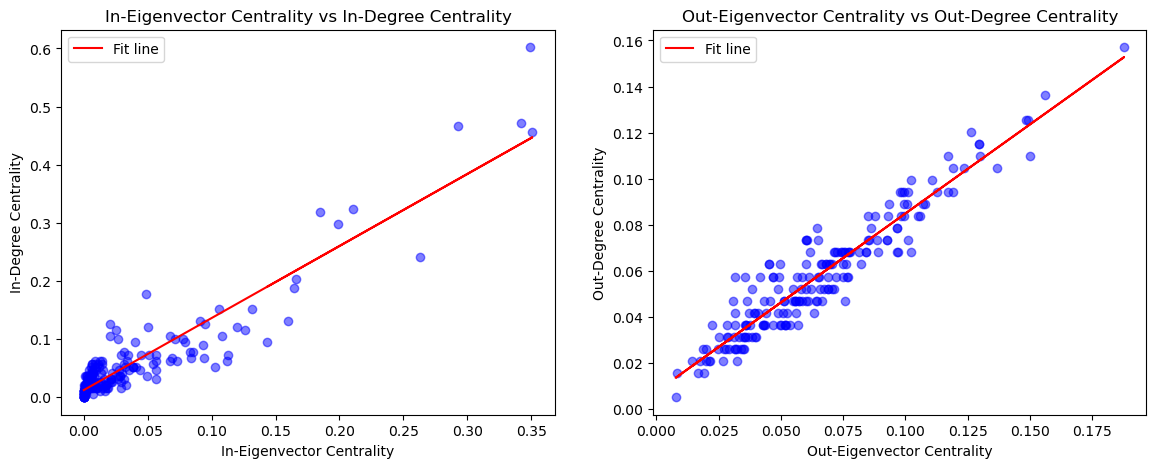

In [15]:
ineig_c_list = list(ineig_c.values())
outeig_c_list = list(outeig_c.values())

pearson_corr_in = pearsonr(ineig_c_list, indegree_c_list)
pearson_corr_out = pearsonr(outeig_c_list, outdegree_c_list)
print("Pearson correlation (In-Degree vs In-Eigenvector):", pearson_corr_in[0])
print("Pearson correlation (Out-Degree vs Out-Eigenvector):", pearson_corr_out[0])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(ineig_c_list, indegree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(ineig_c_list, indegree_c_list, 1)
axes[0].plot(ineig_c_list, slope * np.array(ineig_c_list) + intercept, color='red', label='Fit line')
axes[0].set_title(f"In-Eigenvector Centrality vs In-Degree Centrality")
axes[0].set_xlabel("In-Eigenvector Centrality")
axes[0].set_ylabel("In-Degree Centrality")
axes[0].legend()

axes[1].scatter(outeig_c_list, outdegree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(outeig_c_list, outdegree_c_list, 1)
axes[1].plot(outeig_c_list, slope * np.array(outeig_c_list) + intercept, color='red', label='Fit line')
axes[1].set_title(f"Out-Eigenvector Centrality vs Out-Degree Centrality")
axes[1].set_xlabel("Out-Eigenvector Centrality")
axes[1].set_ylabel("Out-Degree Centrality")
axes[1].legend()
plt.show()

## 5. Assortativity

**Degree assortativity**

In [16]:
G_und=G.to_undirected(reciprocal=False, as_view=False)
degree_assort=nx.degree_assortativity_coefficient(G_und)
print("Degree assortativity coefficient:", degree_assort)

Degree assortativity coefficient: -0.17715975837934467


**Assortativity relative to gdp**

In [17]:
degree_gdp=nx.attribute_assortativity_coefficient(G_und,"gdp")
print("GDP assortativity coefficient:", degree_gdp)

GDP assortativity coefficient: -0.009018909957192293


**Assortativity relative to language**

In [18]:
degree_language=nx.attribute_assortativity_coefficient(G_und,"official_language")
print("Language assortativity coefficient:", degree_language)

Language assortativity coefficient: 0.11952801260930632


**Assortativity relative to continent**

In [19]:
degree_continent=nx.attribute_assortativity_coefficient(G_und,"continent")
print("Continent assortativity coefficient:", degree_continent)

Continent assortativity coefficient: 0.38825608263098754


## 6. Backbone structure

The backbone structure of the original network was extracted using the backbone extraction package by Michele Coscia. Edge betweenness centrality, which measures the number of shortest paths passing through each edge, was used to assign weights to the network edges, while the disparity filter from the backbone extraction package provided a significance score for each edge, allowing us to retain only the most important connections. The threshold was chosen to preserve the core structure and connectivity without excessive fragmentation, ensuring the analysis remains meaningful.

In [21]:


G_copy = G_und.copy()
edge_bet = nx.edge_betweenness_centrality(G_copy)

# normalize to [0, 100]
values = np.array(list(edge_bet.values()))
v_min, v_max = values.min(), values.max()
edge_bet_norm = 1 + 99 * (values - v_min) / (v_max - v_min)

# assign normalized weights to edges
for (edge, norm_val) in zip(edge_bet.keys(), edge_bet_norm):
    u, v = edge
    G_copy[u][v]['weight'] = norm_val

# table with src, trg and nij
edges = nx.to_pandas_edgelist(G_copy)
edges.rename(columns={'source':'src', 'target':'trg', 'weight':'nij'}, inplace=True)

# method to add score, use disparity filter
disparity_filter = backboning.disparity_filter(edges, undirected=True)
# threshold the scores and get the backbone structure
backbone_edges = backboning.thresholding(disparity_filter, threshold=0.7)

# convert table into network x
G_backbone = nx.from_pandas_edgelist(backbone_edges, source='src', target='trg', edge_attr='score')

print(f"Original Undirected Network: {len(G_copy.nodes())} nodes, {len(G_und.edges())} edges")
print(f"Backbone Network: {len(G_backbone.nodes())} nodes, {len(G_backbone.edges())} edges")

components = list(nx.connected_components(G_backbone))
print(f"\nBackbone network has {len(components)} components")
print("Sizes of components:", [len(c) for c in components])

largest_component = max(components, key=len)
G_largest = G_backbone.subgraph(largest_component).copy()

Original Undirected Network: 192 nodes, 1748 edges
Backbone Network: 167 nodes, 360 edges

Backbone network has 1 components
Sizes of components: [167]


Calculating DF score...


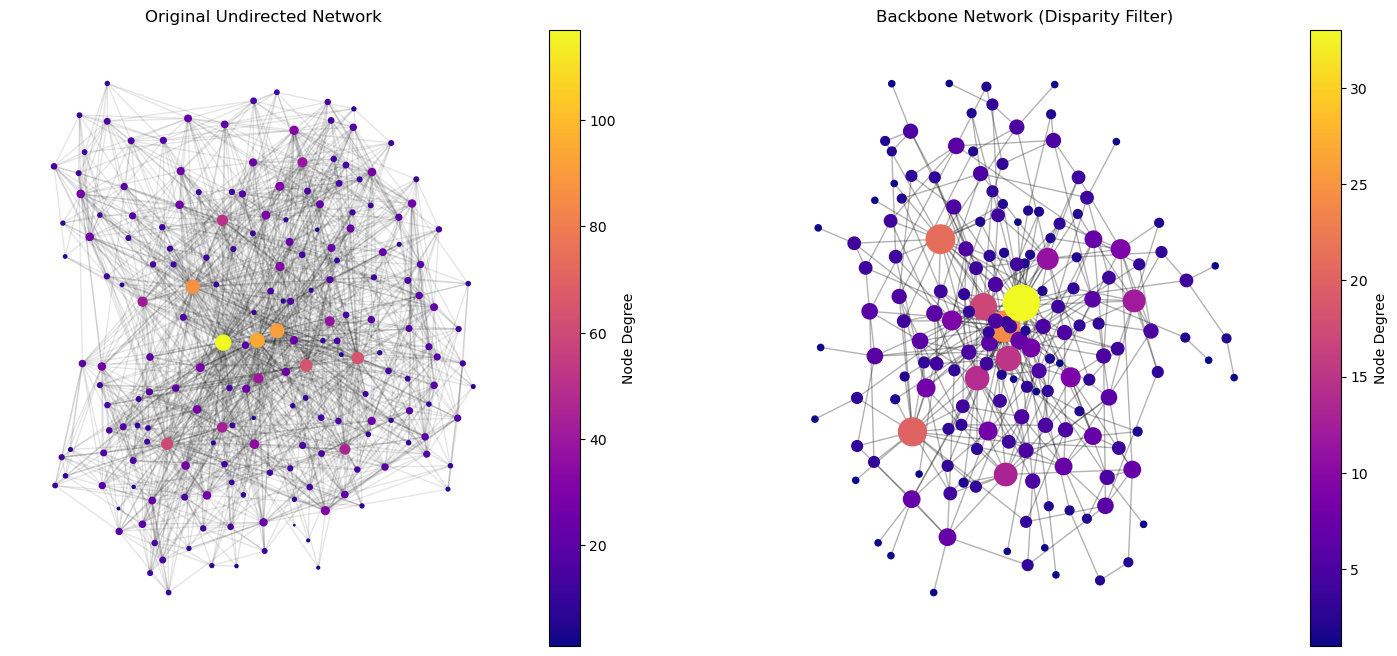

In [22]:
degrees_orig = dict(G_copy.degree())
degrees_back = dict(G_backbone.degree())

# node size
node_size_orig = [degrees_orig[n] for n in G_copy.nodes()]
node_size_back = [degrees_back[n]*20 for n in G_backbone.nodes()]

# node color
node_color_orig = [degrees_orig[n] for n in G_copy.nodes()]
node_color_back = [degrees_back[n] for n in G_backbone.nodes()]

pos_springf_orig = nx.forceatlas2_layout(G_copy, max_iter=100, gravity=25)
pos_springf_back = nx.forceatlas2_layout(G_backbone, max_iter=100, gravity=25)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
nodes_orig=nx.draw_networkx_nodes(G_copy, pos=pos_springf_orig, node_size=node_size_orig, node_color=node_color_orig, cmap=plt.cm.plasma, ax=axes[0])
nx.draw_networkx_edges(G_copy, pos=pos_springf_orig, alpha=0.1, ax=axes[0])
axes[0].set_title("Original Undirected Network")
axes[0].axis("off")
cbar_orig = plt.colorbar(nodes_orig, ax=axes[0])
cbar_orig.set_label("Node Degree")

nodes_back=nx.draw_networkx_nodes(G_backbone, pos=pos_springf_back, node_size=node_size_back, node_color=node_color_back, cmap=plt.cm.plasma, ax=axes[1])
nx.draw_networkx_edges(G_backbone, pos=pos_springf_back, alpha=0.3, ax=axes[1])
axes[1].set_title("Backbone Network (Disparity Filter)")
axes[1].axis("off")
cbar_back = plt.colorbar(nodes_back, ax=axes[1])
cbar_back.set_label("Node Degree")
plt.show()

By comparing the highest-degree nodes in the original and backbone networks, we conclude that nodes appearing in both lists are highly influential countries that also have a structural importance, as they retain key connections in the backbone.

In [23]:
# Highest degree nodes in original network
deg_orig = dict(G_copy.degree())
top_orig = sorted(deg_orig.items(), key=lambda x: x[1], reverse=True)[:10]

# Highest degree nodes in backbone network
deg_back = dict(G_largest.degree())
top_back = sorted(deg_back.items(), key=lambda x: x[1], reverse=True)[:10]

df_top = pd.DataFrame({
    "Original Network": [node for node, _ in top_orig],
    "Backbone Network": [node for node, _ in top_back],
})

print("Top 10 Highest Degree Nodes in Original and Backbone Networks:")
display(df_top)

common_nodes = set([node for node, _ in top_orig]) & set([node for node, _ in top_back])
print("\nNodes appearing in both top 10 lists:", common_nodes)

Top 10 Highest Degree Nodes in Original and Backbone Networks:


,Original Network,Backbone Network
0,United_States,United_States
1,United_Kingdom,United_Kingdom
2,France,Germany
3,Germany,France
4,China,Spain
5,India,Russia
6,Spain,China
7,Russia,India
8,Portugal,Portugal
9,Cuba,Nicaragua



Nodes appearing in both top 10 lists: {'Portugal', 'France', 'United_Kingdom', 'Russia', 'India', 'Germany', 'United_States', 'Spain', 'China'}


Centrality measures

In [24]:
degree_c = nx.degree_centrality(G_largest)
bet_c = nx.betweenness_centrality(G_largest)
eigen_c = nx.eigenvector_centrality(G_largest, max_iter=1000)

sorted_degree = sorted(degree_c.items(), key=lambda x: x[1], reverse=True)
top5_deg = [sorted_degree[i][0] for i in range(5)]
print("Top 5 nodes by degree centrality:", top5_deg)

sorted_bet= sorted(bet_c.items(), key=lambda x: x[1], reverse=True)
top5_bet = [sorted_bet[i][0] for i in range(5)]
print("Top 5 nodes by betweenness centrality:", top5_bet)

sorted_eigen = sorted(eigen_c.items(), key=lambda x: x[1], reverse=True)
top5_eigen = [sorted_eigen[i][0] for i in range(5)]
print("Top 5 nodes by eigenvector centrality:", top5_eigen)

Top 5 nodes by degree centrality: ['United_States', 'United_Kingdom', 'Germany', 'France', 'Spain']
Top 5 nodes by betweenness centrality: ['United_States', 'United_Kingdom', 'Germany', 'France', 'Russia']
Top 5 nodes by eigenvector centrality: ['United_States', 'United_Kingdom', 'Russia', 'Germany', 'China']


Correlations between betweenness, degree and eigenvector centrality.

Pearson correlation (Betweenness vs Degree Centrality): 0.960706688087999
Pearson correlation (Eigenvector vs Degree Centrality): 0.8367400662132344


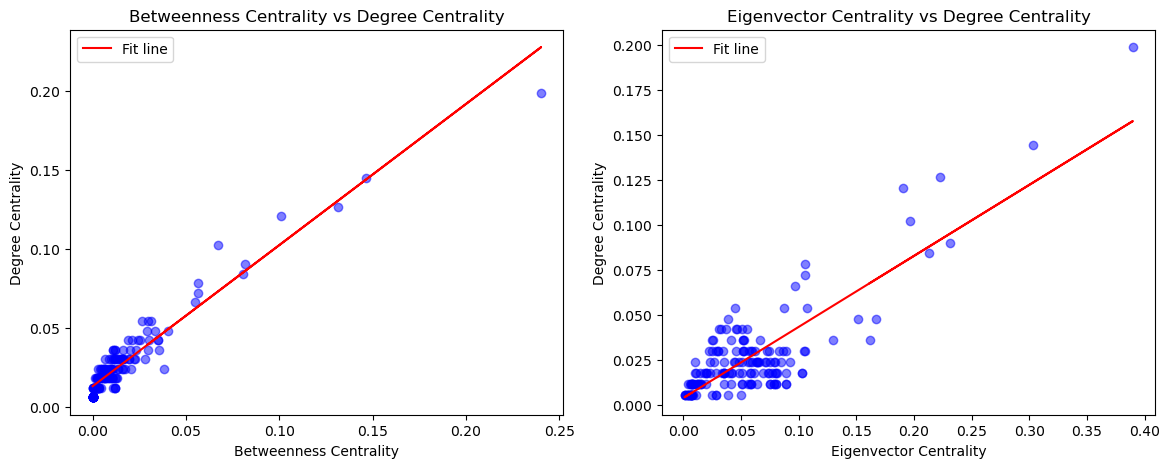

In [25]:
from scipy.stats import pearsonr

degree_c_list = list(degree_c.values())
bet_c_list = list(bet_c.values())
eigen_c_list = list(eigen_c.values())

pearson_corr_bet = pearsonr(bet_c_list, degree_c_list)
print("Pearson correlation (Betweenness vs Degree Centrality):", pearson_corr_bet[0])

pearson_corr_eig = pearsonr(eigen_c_list, degree_c_list)
print("Pearson correlation (Eigenvector vs Degree Centrality):", pearson_corr_eig[0])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(bet_c_list, degree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(bet_c_list, degree_c_list, 1)
axes[0].plot(bet_c_list, slope * np.array(bet_c_list) + intercept, color='red', label='Fit line')
axes[0].set_title(f"Betweenness Centrality vs Degree Centrality")
axes[0].set_xlabel("Betweenness Centrality")
axes[0].set_ylabel("Degree Centrality")
axes[0].legend()

axes[1].scatter(eigen_c_list, degree_c_list, alpha=0.5, c='blue')
slope, intercept = np.polyfit(eigen_c_list, degree_c_list, 1)
axes[1].plot(eigen_c_list, slope * np.array(eigen_c_list) + intercept, color='red', label='Fit line')
axes[1].set_title(f"Eigenvector Centrality vs Degree Centrality")
axes[1].set_xlabel("Eigenvector Centrality")
axes[1].set_ylabel("Degree Centrality")
axes[1].legend()
plt.show()